# CIS520 Project
## Part I - Data Processing
##### install Ta-lib
* **on Mac OS**
    * brew ta-lib
    * pip install ta-lib
    * ref https://mrjbq7.github.io/ta-lib/install.html
* **Ubuntu**
    * find pat -- `pwd`
    * ref https://blog.csdn.net/weixin_40327641/article/details/81076438

In [ ]:
# !pip install plotly
# !pip install cufflinks

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import talib as ta
import seaborn as sns
# sns.set_style('whitegrid')
# %matplotlib inline
# Optional Plotly Method Imports
import plotly
import cufflinks as cf
cf.go_offline()
# os.chdir("/Users/joecao/Documents/Upenn/Courses/CIS520/cis520project")  # change root directory
os.chdir("/home/josephkeecaoqi/cis520project")  # change root directory
engine = sqlite3.connect('stock_price_DB')

### Data Wrangling
    √ Imported 7 stocks
    √ Modified Column Name
    √ Transferred Date column into datetime type  
    √ Missing value checked   
        * amdRaw_df.isnull().any()  
        * googleRaw_df.isnull().any()
    √ Stored data in database stock_price_DB

In [2]:
amd_raw_df=pd.read_csv('raw_data/amd.csv')
google_raw_df=pd.read_csv('raw_data/google.csv')
ge_raw_df=pd.read_csv('raw_data/ge_us.csv').drop(columns='OpenInt')
hpq_raw_df=pd.read_csv('raw_data/hpq_us.csv').drop(columns='OpenInt')

In [3]:
amd_raw_df.columns=['date','open','high','low','close','adj_close','volume']
google_raw_df.columns=['date','open','high','low','close','adj_close','volume']
ge_raw_df.columns=['date','open','high','low','close','volume']
hpq_raw_df.columns=['date','open','high','low','close','volume']

In [4]:
amd_raw_df['date']=pd.to_datetime(amd_raw_df['date'],format='%Y-%m-%d')
google_raw_df['date']=pd.to_datetime(google_raw_df['date'],format='%Y-%m-%d')
ge_raw_df['date']=pd.to_datetime(ge_raw_df['date'],format='%Y-%m-%d')
hpq_raw_df['date']=pd.to_datetime(hpq_raw_df['date'],format='%Y-%m-%d')

In [5]:
amd_raw_df.to_sql('amd_raw',con=engine,if_exists='replace',index=False)
google_raw_df.to_sql('google_raw',con=engine,if_exists='replace',index=False)
ge_raw_df.to_sql('ge_raw',con=engine,if_exists='replace',index=False)
hpq_raw_df.to_sql('hpq_raw',con=engine,if_exists='replace',index=False)

In [6]:
amd_raw_df=pd.read_sql_query('select * from amd_raw', engine).set_index('date')
google_raw_df=pd.read_sql_query('select * from google_raw', engine)
ge_raw_df=pd.read_sql_query('select * from ge_raw', engine)
hpq_raw_df=pd.read_sql_query('select * from hpq_raw', engine)

In [8]:
amd_raw_df.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2009-05-22 00:00:00,4.43,4.43,4.25,4.26,4.26,8274300
2009-05-26 00:00:00,4.26,4.57,4.23,4.53,4.53,16094300
2009-05-27 00:00:00,4.57,4.80,4.55,4.71,4.71,21512600
2009-05-28 00:00:00,4.75,4.84,4.54,4.70,4.70,18383900
2009-05-29 00:00:00,4.71,4.78,4.38,4.54,4.54,24539700


### Creating Features
    √ Created Features by indicators 
        * using ta-lib and following the built-in function to create ~115 features.   
        * Reference-- https://mrjbq7.github.io/ta-lib/
    √ Created label trend = {0,1}, for ith day, trend=(sign(price(i+1)-price(i))+1)/2 
    √ Removed features with all zero elements

In [9]:
def create_features(raw_df):
    processed_df=raw_df.copy()
    processed_df['adx']=ta.ADX(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['adxr'] = ta.ADXR(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['apo'] = ta.APO(raw_df.close, fastperiod=12, slowperiod=26, matype=0)
    processed_df['aroon_up'],processed_df['aroon_dn']=ta.AROON(raw_df.high, raw_df.low, timeperiod=25)
    processed_df['aroon_osc']=ta.AROONOSC(raw_df.high, raw_df.low, timeperiod=25)
    processed_df['bop'] = ta.BOP(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['cci'] = ta.CCI(raw_df.high, raw_df.low, raw_df.close, timeperiod=20) #lable days=20
    processed_df['cmo'] = ta.CMO(raw_df.close, timeperiod=14)
    processed_df['dx'] = ta.DX(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['macd'], processed_df['macdsignal'], processed_df['macdhist'] = ta.MACD(raw_df.close, fastperiod=12, slowperiod=26, signalperiod=9)
    processed_df['macd_ext'], processed_df['macdsignal_ext'], processed_df['macdhist_ext'] = ta.MACDEXT(raw_df.close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
    processed_df['macd_fix'], processed_df['macdsignal_fix'], processed_df['macdhist'] = ta.MACDFIX(raw_df.close, signalperiod=9)
    processed_df['mfi'] = ta.MFI(raw_df.high, raw_df.low, raw_df.close, raw_df.volume, timeperiod=14)
    processed_df['minus_di'] = ta.MINUS_DI(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['minus_dm'] = ta.MINUS_DM(raw_df.high, raw_df.low, timeperiod=14)
    processed_df['mom'] = ta.MOM(raw_df.close, timeperiod=10)
    processed_df['plus_di'] = ta.PLUS_DI(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['plus_dm'] = ta.PLUS_DM(raw_df.high, raw_df.low, timeperiod=14)
    processed_df['rpo'] = ta.PPO(raw_df.close, fastperiod=12, slowperiod=26, matype=0)
    processed_df['roc'] = ta.ROC(raw_df.close, timeperiod=10)
    processed_df['rocp'] = ta.ROCP(raw_df.close, timeperiod=10)
    processed_df['rocr'] = ta.ROCR(raw_df.close, timeperiod=10)
    processed_df['rocr100'] = ta.ROCR100(raw_df.close, timeperiod=10)
    processed_df['rsi'] = ta.RSI(raw_df.close, timeperiod=14)
    processed_df['slowk'], processed_df['slowd'] = ta.STOCH(raw_df.high, raw_df.low, raw_df.close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    processed_df['fastk'], processed_df['fastd'] = ta.STOCHF(raw_df.high, raw_df.low, raw_df.close, fastk_period=5, fastd_period=3, fastd_matype=0)
    processed_df['fastk'], processed_df['fastd'] = ta.STOCHRSI(raw_df.close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    processed_df['trix'] = ta.TRIX(raw_df.close, timeperiod=30)
    processed_df['ult_osc'] = ta.ULTOSC(raw_df.high, raw_df.low, raw_df.close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    processed_df['willr'] = ta.WILLR(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    # -------------- Volume Indicator Function ---------
    processed_df['ad']=ta.AD(raw_df.high,raw_df.low,raw_df.close,raw_df.volume)
    processed_df['ad_osc'] = ta.ADOSC(raw_df.high,raw_df.low,raw_df.close,raw_df.volume, fastperiod=3, slowperiod=10)
    processed_df['obv']= ta.OBV(raw_df.close, raw_df.volume)
    # --------------- Volatility Indicator Functions ---------
    processed_df['atr'] = ta.ATR(raw_df.high,raw_df.low,raw_df.close, timeperiod=14)
    processed_df['natr'] = ta.NATR(raw_df.high,raw_df.low,raw_df.close, timeperiod=14)
    processed_df['tr']= ta.TRANGE(raw_df.high,raw_df.low,raw_df.close)
    # --------------- Price Transformation Functions -------
    processed_df['avg_price'] = ta.AVGPRICE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['median_price'] = ta.MEDPRICE(raw_df.high, raw_df.low)
    processed_df['typical_price'] = ta.TYPPRICE(raw_df.high, raw_df.low, raw_df.close)
    processed_df['weighted_close_price'] = ta.WCLPRICE(raw_df.high, raw_df.low, raw_df.close)
    # ------------------ Cycle Indicator Functions -------
    processed_df['ht_domint_cycle_period'] = ta.HT_DCPERIOD(raw_df.close)
    processed_df['ht_dominent_cycle_phase'] = ta.HT_DCPHASE(raw_df.close)
    processed_df['ht_phasor_inphase'], processed_df['ht_phasor_quadrature'] = ta.HT_PHASOR(raw_df.close)
    processed_df['ht_sine'], processed_df['ht_leadsine'] = ta.HT_SINE(raw_df.close)
    processed_df['ht_trend_mode'] = ta.HT_TRENDMODE(raw_df.close)
    # ----------------- Statistic Functions -----------
    processed_df['beta'] = ta.BETA(raw_df.high, raw_df.low, timeperiod=5)
    processed_df['corr'] = ta.CORREL(raw_df.high, raw_df.low, timeperiod=30)
    processed_df['linear_reg'] = ta.LINEARREG(raw_df.close, timeperiod=14)
    processed_df['linear_reg_angle'] = ta.LINEARREG_ANGLE(raw_df.close, timeperiod=14)
    processed_df['linear_reg_intercept'] = ta.LINEARREG_INTERCEPT(raw_df.close, timeperiod=14)
    processed_df['linear_reg_slope'] = ta.LINEARREG_SLOPE(raw_df.close, timeperiod=14)
    processed_df['std_dev'] = ta.STDDEV(raw_df.close, timeperiod=5, nbdev=1)
    processed_df['time_series_forecast'] = ta.TSF(raw_df.close, timeperiod=14)
    processed_df['variance'] = ta.VAR(raw_df.close, timeperiod=5, nbdev=1)
    # --------------- Pattern Recognition Functions --------
    processed_df['two_crows'] = ta.CDL2CROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_black_crows'] = ta.CDL3BLACKCROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_inside'] = ta.CDL3INSIDE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_line_strike'] = ta.CDL3LINESTRIKE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_outside'] = ta.CDL3OUTSIDE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_stars_in_south'] = ta.CDL3STARSINSOUTH(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_white_soldiers'] = ta.CDL3WHITESOLDIERS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['abandoned_baby'] = ta.CDLABANDONEDBABY(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['advance_block'] = ta.CDLADVANCEBLOCK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['belt_hold'] = ta.CDLBELTHOLD(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['break_away'] = ta.CDLBREAKAWAY(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['closing_marubozu'] = ta.CDLCLOSINGMARUBOZU(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['concealing_baby_swallow'] = ta.CDLCONCEALBABYSWALL(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['counter_attack'] = ta.CDLCOUNTERATTACK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['dark_cloud_cover'] = ta.CDLDARKCLOUDCOVER(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['doji'] = ta.CDLDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['doji_star'] = ta.CDLDOJISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['dragonfly_doji'] = ta.CDLDRAGONFLYDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['engulfing'] = ta.CDLENGULFING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['evening_doji_star'] = ta.CDLEVENINGDOJISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['evening_star'] = ta.CDLEVENINGSTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['gap_side2_white'] = ta.CDLGAPSIDESIDEWHITE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['gravestone_doji'] = ta.CDLGRAVESTONEDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hammer'] = ta.CDLHAMMER(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hanging_man'] = ta.CDLHANGINGMAN(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['harami'] = ta.CDLHARAMI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['harami_cross'] = ta.CDLHARAMICROSS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['high_wave'] = ta.CDLHIGHWAVE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hikkake_pattern'] = ta.CDLHIKKAKE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hikkake_mod'] = ta.CDLHIKKAKEMOD(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['homing_pigeon'] = ta.CDLHOMINGPIGEON(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['identical_three_crows'] = ta.CDLIDENTICAL3CROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['in_nect'] = ta.CDLINNECK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['inverted_hammer'] = ta.CDLINVERTEDHAMMER(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['kicking'] = ta.CDLKICKING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['kicking_by_length'] = ta.CDLKICKINGBYLENGTH(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['ladder_bottom'] = ta.CDLLADDERBOTTOM(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['long_legged_doji'] = ta.CDLLONGLEGGEDDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['long_line_candle'] = ta.CDLLONGLINE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['marubozu'] = ta.CDLMARUBOZU(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['matching_low'] = ta.CDLMATCHINGLOW(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['mat_hold'] = ta.CDLMATHOLD(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['morning_doji_star'] = ta.CDLMORNINGDOJISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['morning_star'] = ta.CDLMORNINGSTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['on_neck'] = ta.CDLONNECK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['piercing'] = ta.CDLPIERCING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['rickshaw_man'] = ta.CDLRICKSHAWMAN(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['rising_fall_3methods'] = ta.CDLRISEFALL3METHODS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['separating_lines'] = ta.CDLSEPARATINGLINES(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['shooting_star'] = ta.CDLSHOOTINGSTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['short_line'] = ta.CDLSHORTLINE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['spinning_top'] = ta.CDLSPINNINGTOP(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['stalled_pattern'] = ta.CDLSTALLEDPATTERN(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['stick_sandwich'] = ta.CDLSTICKSANDWICH(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['takuri'] = ta.CDLTAKURI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['tasuki_gap'] = ta.CDLTASUKIGAP(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['thrusting'] = ta.CDLTHRUSTING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['tri_star'] = ta.CDLTRISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['unique_three_river'] = ta.CDLUNIQUE3RIVER(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['upside_gap_two_crows'] = ta.CDLUPSIDEGAP2CROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['xside_three_methods'] = ta.CDLXSIDEGAP3METHODS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['trend']=(np.sign(+raw_df.close.shift(-1)-raw_df.close+0.00001)+1)/2  
    return processed_df


In [11]:
def drop_all_zero_cols(df):
    ''' drop columns with all elements are zero
    input: dataframe
    output: processed dataframe
    '''
    cols_zero_min=df.columns[df.min()==0]
    temp_df=df[cols_zero_min]
    cols_zero_min_zero_max=temp_df.columns[temp_df.max()==0]
    return df.drop(columns=cols_zero_min_zero_max)

#### Creating Feature, Drop all zero column, Drop NaN, Store processed data in database

In [12]:
amd_df=create_features(amd_raw_df)
amd_df=drop_all_zero_cols(amd_df)
amd_df.to_sql('amd',con=engine,if_exists='replace',index=False)

In [13]:
google_df=create_features(google_raw_df)
google_df=drop_all_zero_cols(google_df)
google_df.to_sql('google',con=engine,if_exists='replace',index=False)

In [14]:
ge_df=create_features(ge_raw_df)
ge_df=drop_all_zero_cols(ge_df)
ge_df.to_sql('ge',con=engine,if_exists='replace',index=False)

In [15]:
hpq_df=create_features(hpq_raw_df)
hpq_df=drop_all_zero_cols(hpq_df)
hpq_df.to_sql('hpq',con=engine,if_exists='replace',index=False)

In [16]:
amd_df.head()

,open,high,low,close,adj_close,volume,adx,adxr,apo,aroon_up,...,spinning_top,stalled_pattern,stick_sandwich,takuri,tasuki_gap,thrusting,tri_star,unique_three_river,xside_three_methods,trend
date,,,,,,,,,,,,,,,,,,,,,
2009-05-22 00:00:00,4.43,4.43,4.25,4.26,4.26,8274300,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
2009-05-26 00:00:00,4.26,4.57,4.23,4.53,4.53,16094300,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
2009-05-27 00:00:00,4.57,4.80,4.55,4.71,4.71,21512600,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0
2009-05-28 00:00:00,4.75,4.84,4.54,4.70,4.70,18383900,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0
2009-05-29 00:00:00,4.71,4.78,4.38,4.54,4.54,24539700,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0


###### Save as .csv

In [16]:
amd_df.to_csv('amd_processeddata.csv',index=True)
google_df.to_csv('google_processeddata.csv',index=True)
ibm_df.to_csv('ibm_processeddata.csv',index=True)
jpm_df.to_csv('jpm_processeddata.csv',index=True)
hpq_df.to_csv('hpq_processeddata.csv',index=True)
mo_df.to_csv('mo_processeddata.csv',index=True)
ge_df.to_csv('ge_processeddata.csv',index=True)

### Visualization
* Using plot.ly for some plots
* Ref https://www.kaggle.com/ranjitmishra/exploratory-data-analysis-of-stock-prices
#### Price vs. date

In [18]:
# data_df=ibm_df # visualize ibm data
data_df = amd_df.dropna()
# data_df['date']=data_df['date'].todate

<Figure size 432x288 with 0 Axes>

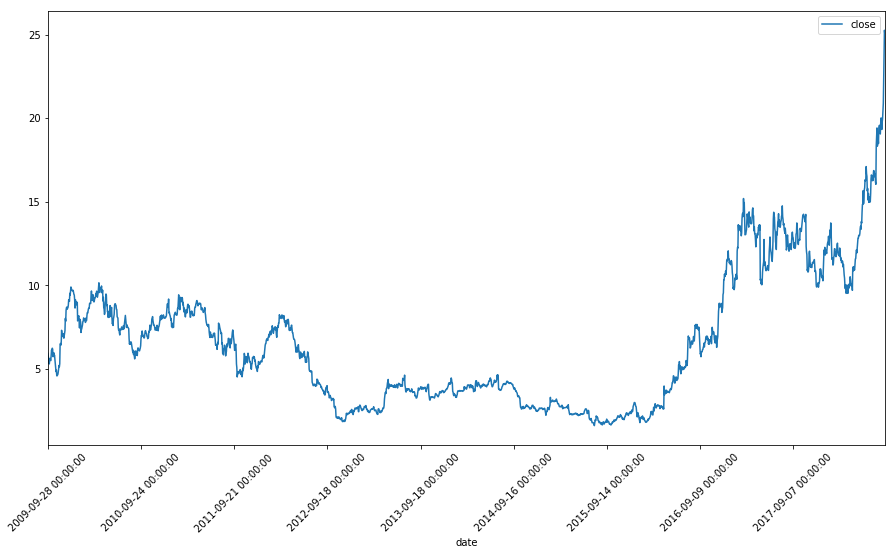

In [19]:
fig=plt.figure()
data_df.plot(y=['close'],figsize=(15,8),rot=45)

#### Interpretation of Selected Feature -- Decompose the time-series data

<Figure size 432x288 with 0 Axes>

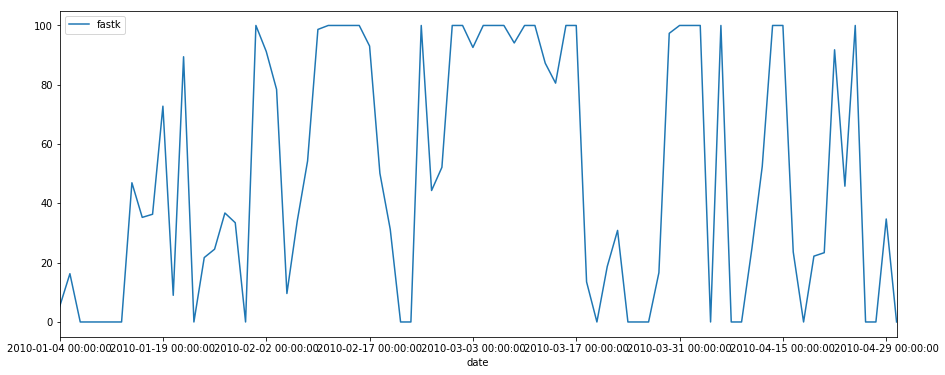

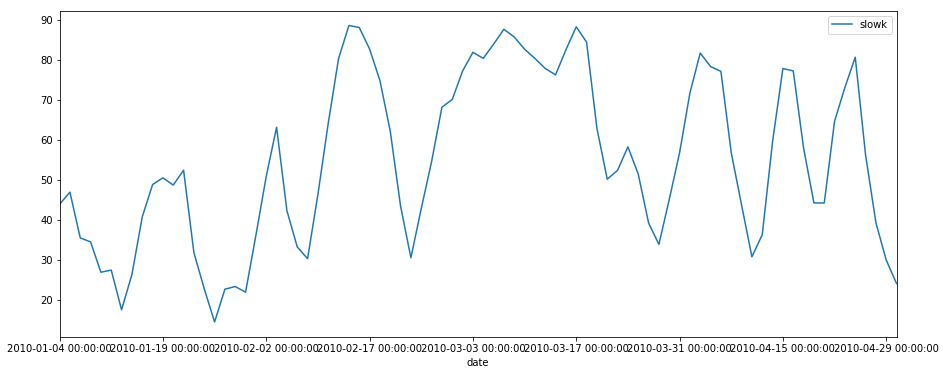

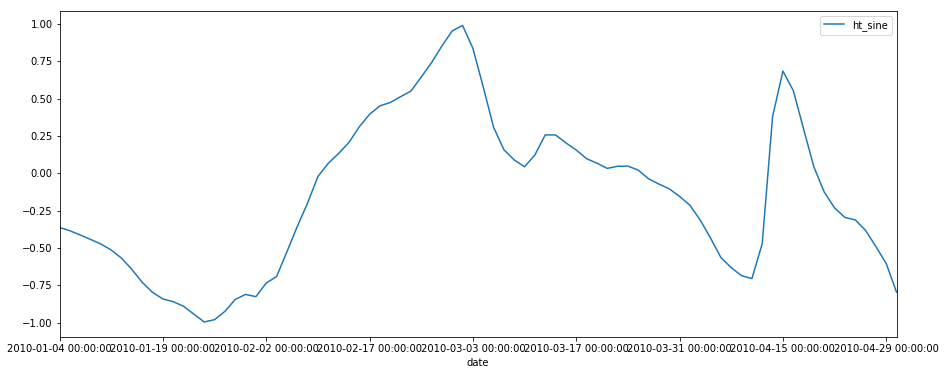

In [20]:
fig=plt.figure()
data_df.loc['2010-01-01':'2010-05-01'].plot(y=['fastk'],figsize=(15,6))
data_df.loc['2010-01-01':'2010-05-01'].plot(y=['slowk'],figsize=(15,6))
data_df.loc['2010-01-01':'2010-05-01'].plot(y=['ht_sine'],figsize=(15,6))

#### Moving Average
* Remove small variations

In [21]:
data_df[['slowk','fastk']].loc['2010-01-15':'2010-05-01'].ta_plot(study='sma',periods=[1],title='Simple Moving Averages')[0]


TypeError: 'NoneType' object is not subscriptable

#### Bollinger Band Plot
* give an upper and lower bound of price

In [22]:
data_df['close'].loc['2015-01-01':'2016-01-01'].ta_plot(study='boll')


#### Variance Analysis

In [23]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
data_df=data_df.drop(columns=['trend']).dropna()
X=data_df.values[:,:]
sc = MinMaxScaler()
X_minmax=sc.fit_transform(X)
data_sc_df=pd.DataFrame(X_minmax,columns=data_df.columns)

                                0
fastk                    0.176401
ht_leadsine              0.133716
aroon_up                 0.127021
aroon_dn                 0.126232
doji                     0.123502
long_legged_doji         0.122867
fastd                    0.112913
willr                    0.095248
rickshaw_man             0.094780
ht_trend_mode            0.094780
aroon_osc                0.093361
ht_sine                  0.091104
ht_dominent_cycle_phase  0.075354
bop                      0.070696
slowk                    0.067484


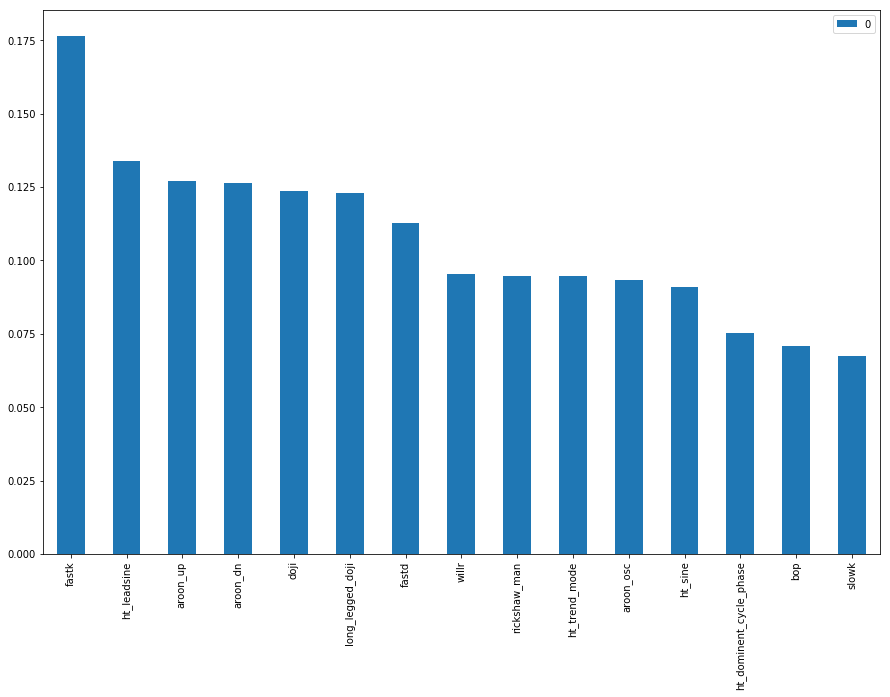

In [24]:
var_df=pd.DataFrame(data_sc_df.var().sort_values(ascending=False))
plot_df=pd.DataFrame(var_df.iloc[:15])
print(plot_df)
plot_df.plot.bar(y=[0],figsize=(15,10))

#### Box Plot
* Make sure these large variance are not resulted by outliers

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

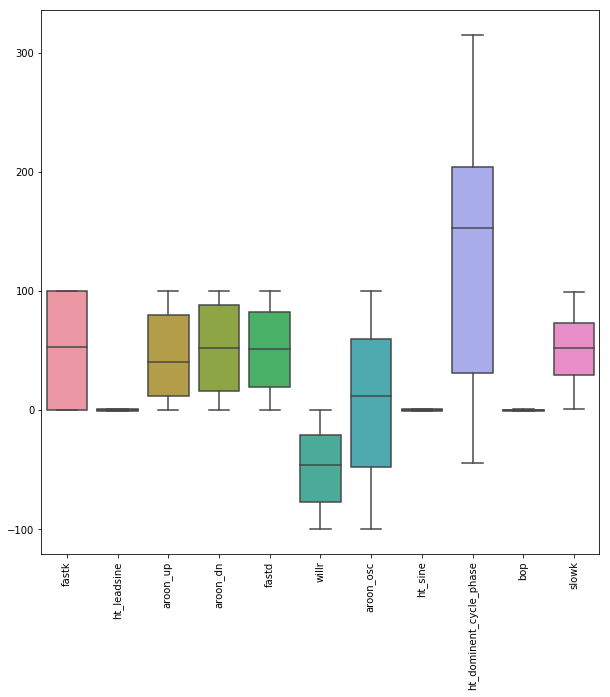

In [25]:
plt.figure(figsize=(10,10))
sns.boxplot( data=data_df[['fastk','ht_leadsine','aroon_up','aroon_dn','fastd','willr','aroon_osc','ht_sine','ht_dominent_cycle_phase','bop','slowk']])
plt.xticks(rotation=90)
# fastk             0.176352
# ht_leadsine       0.133675   # original value -- in 0,1
# aroon_up          0.127056
# aroon_dn          0.126249 
# doji              0.123456   # binary
# long_legged_doji  0.122821   # binary
# fastd             0.112921
# willr             0.095232
# ht_trend_mode     0.094742  # binary
# rickshaw_man      0.094742  # binary
# ht_sine                     # in 0,1
# bop                         # in -1,1

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

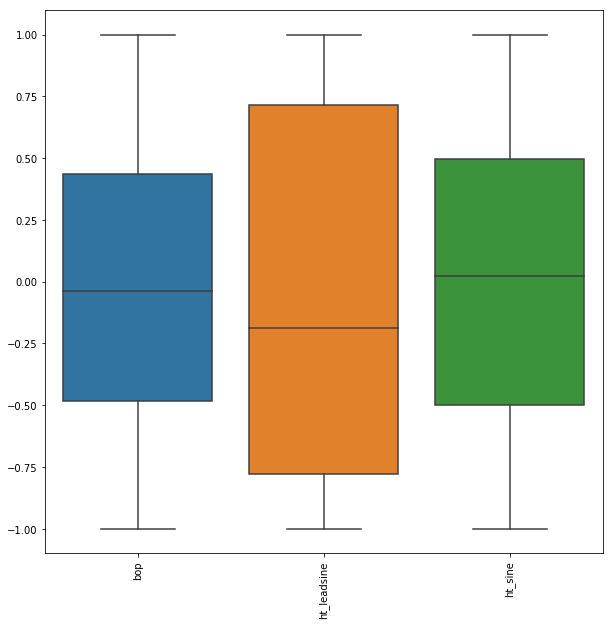

In [26]:
plt.figure(figsize=(10,10))
sns.boxplot( data=data_df[['bop','ht_leadsine','ht_sine']])
plt.xticks(rotation=90)

#### Heat Map of Correlation

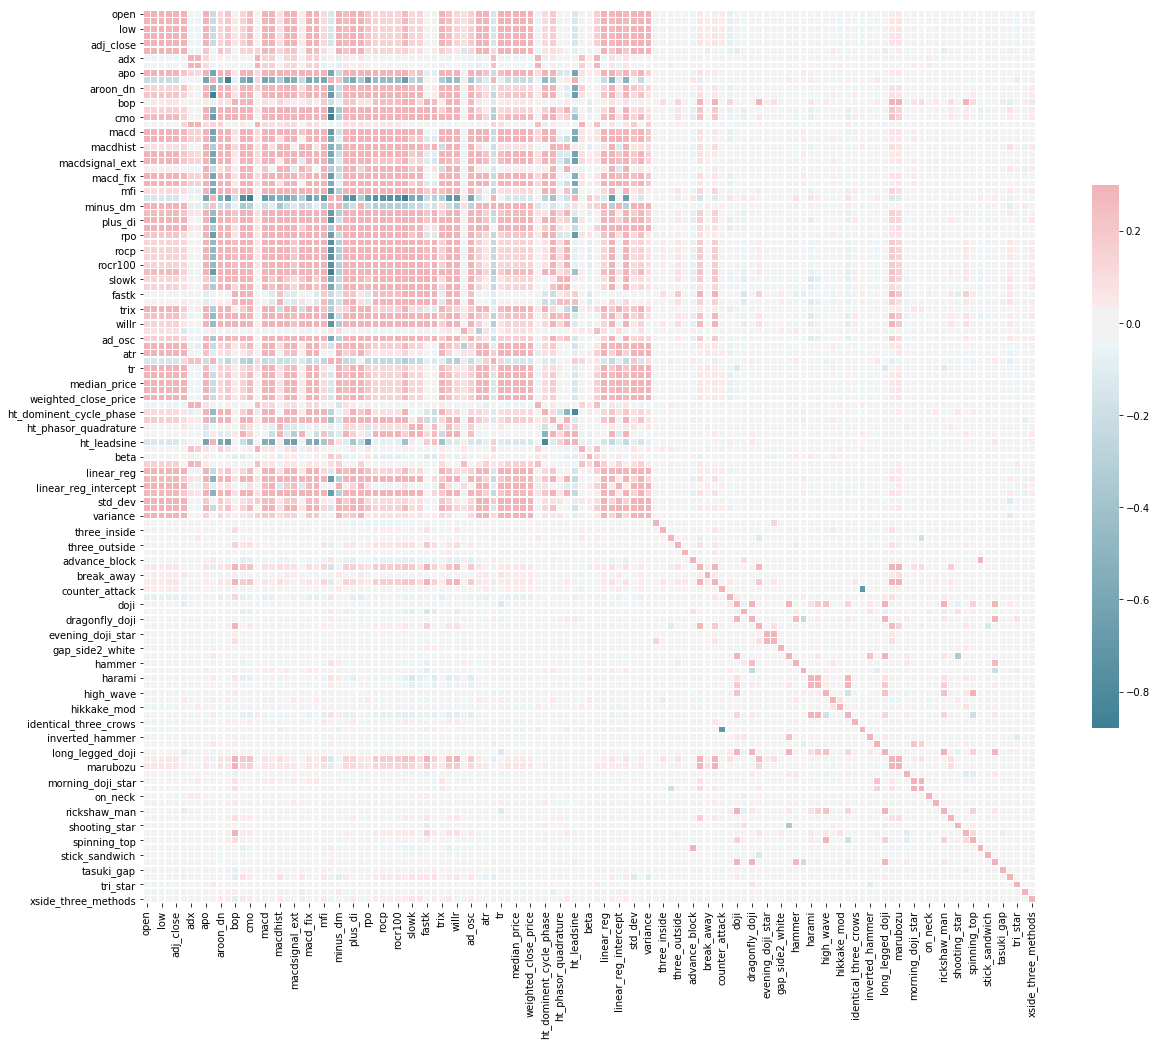

In [27]:
# corr_amd=amd_df.drop(columns='date').corr()
# corr_google=google_df.drop(columns='date').corr()
corr_stock=data_df.corr()
# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_stock, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# reference https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# corr_stock